In [18]:
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import time
import matplotlib
import matplotlib.pyplot as plt

import operator

%matplotlib inline

In [19]:
# 读取文件
train_xy = pd.read_csv("data/train_xy.csv",header=0,sep=",")
train_x = pd.read_csv("data/train_x.csv",header=0,sep=",")
test_all = pd.read_csv("data/test_all.csv",header=0,sep=",")

print(train_xy.shape)
print(train_x.shape)
print(test_all.shape)

(15000, 160)
(10000, 159)
(10000, 159)


In [20]:
train = train_xy.copy()
test = test_all.copy()
test['y'] = -1
# 合并一下train 和 test
data = pd.concat([train,test],axis = 0) # train_xy，test_all索引上连接
print(train.shape)
print(test.shape)
print(data.shape)

(15000, 160)
(10000, 160)
(25000, 160)


d:\python35\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """


In [21]:
# 获取特征列，去除id，group,y
features = [feat for feat in train.columns.values if feat not in ['cust_id','cust_group','y']]
print("所有特征的维度：",len(features))

所有特征的维度： 157


In [22]:
# 得到输入X ，输出y

train_id = train.pop('cust_id')
y = train["y"].values
X = train[features].values
print("X shape:",X.shape)
print("y shape:",y.shape)

test_id = test.pop('cust_id')
test = test[features].values
print("test shape",test.shape)


X shape: (15000, 157)
y shape: (15000,)
test shape (10000, 157)


In [23]:
def ceate_feature_map(features):
    outfile = open('lgb.fmap', 'w',encoding='utf8')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1
    print("map over!")
    outfile.close()

# 特征map文件
ceate_feature_map(features)

map over!


In [24]:
# -----------------LGB tree模型------------------------

In [25]:
# 开始训练

# 采取分层采样
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
import operator
import time

print("start：********************************")
start = time.time()

print('......................Start train all data .......................')

# 最后用全部数据train
train_all = lgb.Dataset(train[features], train['y'])
# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'max_depth': 4,
    'min_child_weight': 6,
    'num_leaves': 16,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    #'lambda_l1':0.25,
    #'lambda_l2':0.5,
    #'scale_pos_weight':1,
}
model = lgb.train(params,
                train_all,
                num_boost_round=450,
                valid_sets=train_all,
                early_stopping_rounds=100,
                verbose_eval=100)

end = time.time()
print("......................run with time: ",(end - start) / 60.0 )
print("over:*********************************")

start：********************************
......................Start train all data .......................
Training until validation scores don't improve for 100 rounds.
[100]	training's auc: 0.848293
[200]	training's auc: 0.866824
[300]	training's auc: 0.88272
[400]	training's auc: 0.895633
Did not meet early stopping. Best iteration is:
[450]	training's auc: 0.901324
......................run with time:  0.029683101177215575
over:*********************************


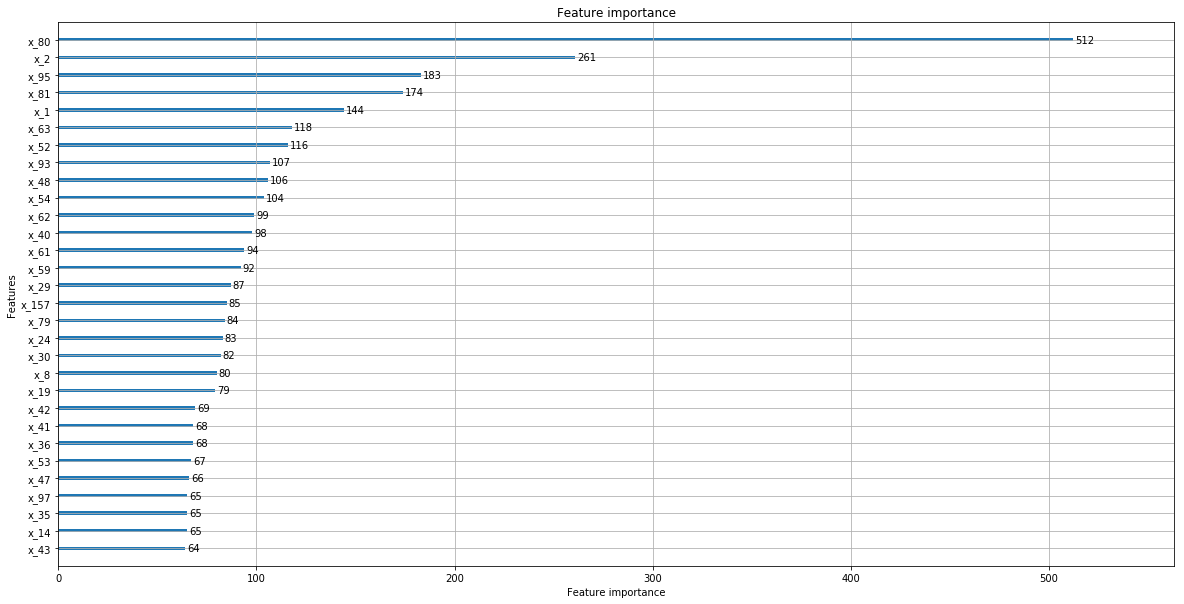

In [26]:
lgb.plot_importance(model,max_num_features = 30,figsize=(20,10))
plt.show()
# 基本都是数值型的特征很有用
# x_157,x_140,x_97

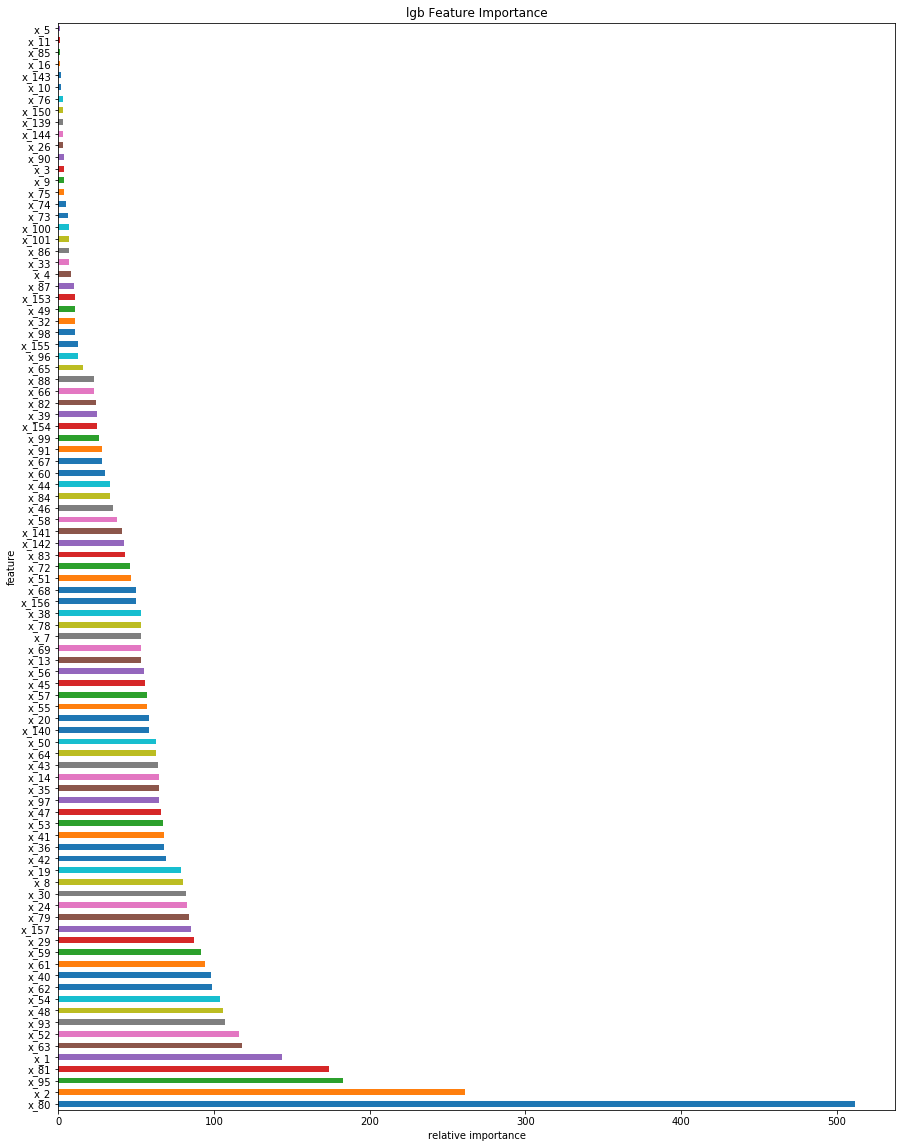

In [27]:
df = pd.DataFrame({'feature': features,'importance': model.feature_importance()}).sort_values(by='importance',ascending = False) # 降序
df.loc[df['importance']!=0,:].plot(kind = 'barh', x='feature', y='importance', legend=False, figsize=(15,20))
plt.title('lgb Feature Importance')
plt.xlabel('relative importance')
plt.show()

In [28]:
# 不等于 0 的特征 
use = df.loc[df['importance']!=0,:]
most_feat = use.iloc[:30,0].values.tolist()
print(most_feat)

['x_80', 'x_2', 'x_95', 'x_81', 'x_1', 'x_63', 'x_52', 'x_93', 'x_48', 'x_54', 'x_62', 'x_40', 'x_61', 'x_59', 'x_29', 'x_157', 'x_79', 'x_24', 'x_30', 'x_8', 'x_19', 'x_42', 'x_36', 'x_41', 'x_53', 'x_47', 'x_97', 'x_35', 'x_14', 'x_43']


In [29]:
# 很多特征重要性为0
df = pd.DataFrame({'feature': features,'importance': model.feature_importance()}).sort_values(by='importance',ascending = True)
df.to_csv('data/feature_imp.csv',index = False)                                    # 157
df.loc[df['importance']==0,:].to_csv('data/feature_0_imp.csv',index = False)       # 64    
df.loc[df['importance']!=0,:].to_csv('data/feature_1_imp.csv',index = False)       # 93

In [30]:
print("特征重要性为0的特征：",df.loc[df['importance']==0,:].shape[0])
df.loc[df['importance']==0,:]

特征重要性为0的特征： 64


,feature,importance
70,x_71,0
145,x_146,0
146,x_147,0
147,x_148,0
148,x_149,0
117,x_118,0
118,x_119,0
119,x_120,0
116,x_117,0
105,x_106,0


In [31]:
# 随机抽取一部分的训练、验证，看看特征重要性
from sklearn.model_selection import StratifiedShuffleSplit
N = 1
skf = StratifiedShuffleSplit(n_splits=N, test_size=0.2, random_state=2018)
for k,(train_in,test_in) in enumerate(skf.split(X,y)):
    X_train,X_test,y_train,y_test = X[train_in],X[test_in],\
                                    y[train_in],y[test_in]
    print("train shape",X_train.shape)
    print("valid shape",X_test.shape)
    # 数据结构
    lgb_train = lgb.Dataset(X_train, y_train, feature_name = features)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    # 设置参数
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': {'auc'},
        'max_depth': 4,
        'min_child_weight': 6,
        'num_leaves': 16,
        'learning_rate': 0.02,
        'feature_fraction': 0.7,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        #'lambda_l1':0.25,
        #'lambda_l2':0.5,
        #'scale_pos_weight':1,
    }

    print('................Start training..........................')
    # train
    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=2000,
                    valid_sets=lgb_eval,
                    early_stopping_rounds=100,
                    verbose_eval=100)

    print('................Start predict .........................')
    # 预测
    y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
    # 评估
    tmp_auc = roc_auc_score(y_test,y_pred)
    print("valid auc:",tmp_auc)
    
    

train shape (12000, 157)
valid shape (3000, 157)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.801915
[200]	valid_0's auc: 0.815503
[300]	valid_0's auc: 0.822699
[400]	valid_0's auc: 0.822243
[500]	valid_0's auc: 0.82396
[600]	valid_0's auc: 0.82176
Early stopping, best iteration is:
[503]	valid_0's auc: 0.824512
................Start predict .........................
valid auc: 0.8245120975501069


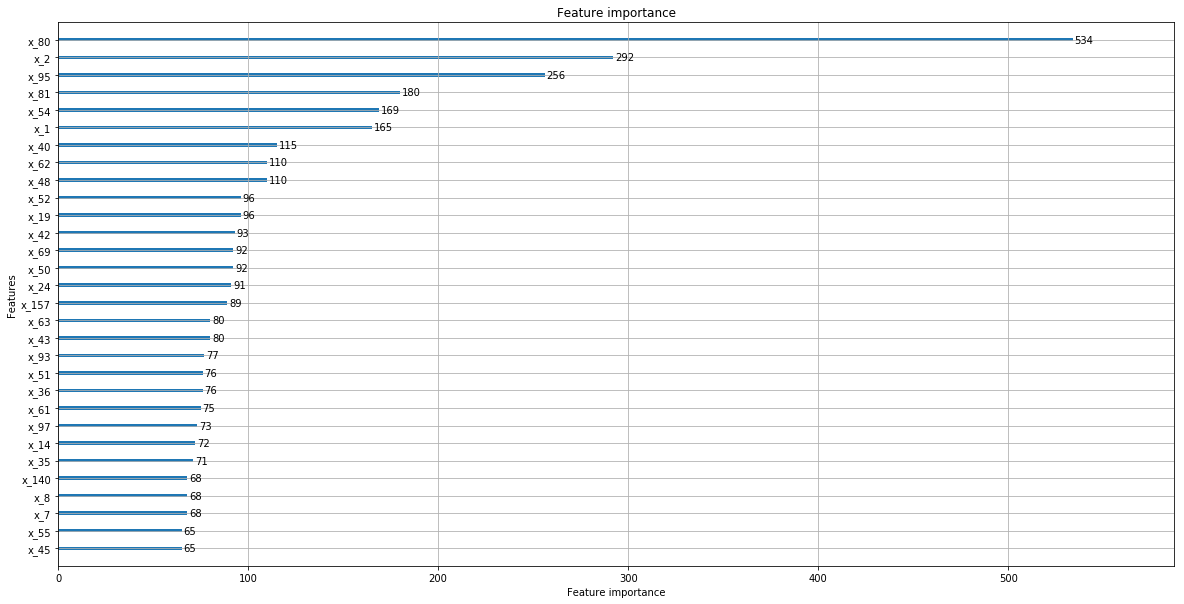

In [32]:
lgb.plot_importance(gbm,max_num_features = 30,figsize=(20,10))
plt.show()
# 基本都是数值型的特征很有用

In [33]:
df1 = pd.DataFrame({'feature': features,'importance': gbm.feature_importance()}).sort_values(by='importance',ascending = True)
df1.to_csv('data/feature_imp1.csv',index = False)                                    # 157
df1.loc[df1['importance']==0,:].to_csv('data/feature_0_imp1.csv',index = False)       # 62    
df1.loc[df1['importance']!=0,:].to_csv('data/feature_1_imp1.csv',index = False)       # 95

aa = df.loc[df['importance']==0,'feature'].values.tolist()
print(len(aa))
bb = df1.loc[df1['importance']==0,'feature'].values.tolist()
print(len(bb))
for i in bb:
    if i not in aa:
        print(i)
# x_86 = 1
# x_75 = 1

64
60


In [34]:
for i in aa:
    if i not in bb:
        print(i)
'''
x_74 = 4
x_10 = 3
x_17 = 2
x_37 = 1

'''

x_77
x_22
x_27
x_6


'\nx_74 = 4\nx_10 = 3\nx_17 = 2\nx_37 = 1\n\n'

In [35]:
print(len(aa))
print(aa)

64
['x_71', 'x_146', 'x_147', 'x_148', 'x_149', 'x_118', 'x_119', 'x_120', 'x_117', 'x_106', 'x_151', 'x_122', 'x_123', 'x_152', 'x_124', 'x_125', 'x_126', 'x_121', 'x_127', 'x_116', 'x_70', 'x_105', 'x_104', 'x_103', 'x_102', 'x_108', 'x_109', 'x_94', 'x_115', 'x_92', 'x_110', 'x_145', 'x_111', 'x_112', 'x_77', 'x_113', 'x_114', 'x_89', 'x_128', 'x_107', 'x_137', 'x_18', 'x_135', 'x_134', 'x_21', 'x_22', 'x_23', 'x_133', 'x_136', 'x_25', 'x_12', 'x_17', 'x_28', 'x_27', 'x_132', 'x_31', 'x_138', 'x_129', 'x_37', 'x_6', 'x_34', 'x_131', 'x_15', 'x_130']


In [36]:
print(len(bb))
print(bb)

60
['x_71', 'x_116', 'x_117', 'x_118', 'x_119', 'x_120', 'x_147', 'x_121', 'x_148', 'x_122', 'x_123', 'x_124', 'x_125', 'x_126', 'x_127', 'x_151', 'x_115', 'x_114', 'x_146', 'x_113', 'x_102', 'x_94', 'x_103', 'x_92', 'x_89', 'x_104', 'x_105', 'x_128', 'x_106', 'x_108', 'x_70', 'x_145', 'x_109', 'x_110', 'x_111', 'x_112', 'x_107', 'x_152', 'x_149', 'x_129', 'x_138', 'x_137', 'x_136', 'x_15', 'x_17', 'x_18', 'x_135', 'x_134', 'x_21', 'x_23', 'x_25', 'x_28', 'x_12', 'x_131', 'x_133', 'x_130', 'x_34', 'x_31', 'x_37', 'x_132']


In [37]:
useless = list(set(aa) & set(bb)) # 交集
print(len(useless))
print(useless)

60
['x_126', 'x_122', 'x_123', 'x_116', 'x_37', 'x_147', 'x_92', 'x_111', 'x_152', 'x_102', 'x_15', 'x_28', 'x_134', 'x_18', 'x_145', 'x_12', 'x_94', 'x_105', 'x_128', 'x_127', 'x_114', 'x_124', 'x_121', 'x_108', 'x_103', 'x_132', 'x_146', 'x_149', 'x_106', 'x_31', 'x_151', 'x_119', 'x_148', 'x_89', 'x_129', 'x_23', 'x_118', 'x_120', 'x_131', 'x_21', 'x_133', 'x_109', 'x_138', 'x_17', 'x_130', 'x_115', 'x_70', 'x_112', 'x_34', 'x_117', 'x_135', 'x_104', 'x_113', 'x_107', 'x_25', 'x_136', 'x_137', 'x_125', 'x_110', 'x_71']


In [38]:
# 自己删除的28个,可以看出，都在重要性为0的范围
cc = ['x_92', 'x_138', 'x_127', 'x_94', 'x_116', 'x_137', 'x_118',
      'x_112', 'x_134', 'x_135', 'x_114', 'x_110', 'x_126', 'x_113', 'x_107', 
      'x_102', 'x_131', 'x_133', 'x_108', 'x_129', 'x_109', 'x_130', 'x_128',
      'x_115', 'x_123', 'x_119', 'x_132', 'x_111']
print(len(cc))
for i in cc:
    if i not in aa:
        print("not aa:",i)
    if i not in bb:
        print('not bb:',i)

28


In [39]:
xx = list(set(useless) - set(cc))
print("多了：",len(xx))
print(xx)

多了： 32
['x_122', 'x_37', 'x_147', 'x_152', 'x_15', 'x_28', 'x_18', 'x_145', 'x_12', 'x_105', 'x_124', 'x_121', 'x_103', 'x_146', 'x_149', 'x_106', 'x_31', 'x_151', 'x_148', 'x_89', 'x_23', 'x_120', 'x_21', 'x_17', 'x_70', 'x_34', 'x_117', 'x_104', 'x_25', 'x_136', 'x_125', 'x_71']


In [40]:
xx = ['x_6', 'x_151', 'x_28', 'x_146', 'x_34', 
      'x_125', 'x_31', 'x_148', 'x_105', 'x_15',
      'x_12', 'x_122', 'x_18', 'x_11', 'x_25',
      'x_106', 'x_152', 'x_70', 'x_149', 'x_124',
      'x_145', 'x_147', 'x_71', 'x_121', 'x_117',
      'x_89', 'x_21', 'x_23', 'x_136', 'x_120', 'x_103', 'x_104']

In [42]:

import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import Series
import matplotlib
import matplotlib.pyplot as plt
import lightgbm as lgb
import operator
import time

%matplotlib inline
# 读取文件
train_xy = pd.read_csv("data/train_xy.csv",header=0,sep=",")
train_x = pd.read_csv("data/train_x.csv",header=0,sep=",")
test_all = pd.read_csv("data/test_all.csv",header=0,sep=",")

print(train_xy.shape)
print(train_x.shape)
print(test_all.shape)

train = train_xy.copy()
test = test_all.copy()
test['y'] = -1
# 合并一下train 和 test
data = pd.concat([train,test],axis = 0) # train_xy，test_all索引上连接
print(train.shape)
print(test.shape)
print(data.shape)

# train ,test 分开分析 
# 处理一下缺失值严重的特征列，删除
def get_nan_feature(train,rate = 0.95):
    total_num = train.shape[0]
    train_nan_feats = []
    for i in range(157):
        feat = 'x_' + str(i+1)
        nan_num = train.loc[train[feat]==-99,:].shape[0]
        nan_rate = nan_num / float(total_num) 
        
        if nan_rate == 1.0:                    # 只有nan
            train_nan_feats.append(feat)
        if nan_rate > rate:                    # 有缺失值 nan,而且缺失严重
            if len(train[feat].unique()) == 2: # 只有nan + 一个其他值
                train_nan_feats.append(feat)

    print("一共有 %d 个特征列的缺失值严重，超过%f "%(len(train_nan_feats),rate))
    return train_nan_feats

train_nan_feats = get_nan_feature(train)
test_nan_feats = get_nan_feature(test)
print("缺失严重的特征：train =？ test------",np.all(train_nan_feats == test_nan_feats))

# 对这些特征取并集
drop_feats = list(set(train_nan_feats) | set(test_nan_feats)) # 按照train | test的结果,并集，交集，A 或者 B 都一样 

print('需要删除的特征有 %d 个。'%(len(drop_feats)))
print(drop_feats)

# 删除缺失值严重的特征列
train = train.drop(drop_feats, axis = 1)
test = test.drop(drop_feats, axis = 1)
data = data.drop(drop_feats, axis = 1)
print(data.shape)
print(train.shape)
print(test.shape)
# 删除的特征，全部是特征重要性=0的特征，所以删除 = 原始的特征（不影响精确效果，但是可以减少噪音）
# 删除了x_92 , x_94 是数值型的，其他 24 个 全部是 类别型

(15000, 160)
(10000, 159)
(10000, 159)
(15000, 160)
(10000, 160)
(25000, 160)


d:\python35\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



一共有 19 个特征列的缺失值严重，超过0.950000 
一共有 26 个特征列的缺失值严重，超过0.950000 
缺失严重的特征：train =？ test------ False
需要删除的特征有 28 个。
['x_126', 'x_123', 'x_116', 'x_92', 'x_111', 'x_102', 'x_134', 'x_94', 'x_128', 'x_127', 'x_114', 'x_108', 'x_132', 'x_119', 'x_129', 'x_118', 'x_131', 'x_133', 'x_138', 'x_109', 'x_130', 'x_112', 'x_115', 'x_135', 'x_113', 'x_107', 'x_137', 'x_110']
(25000, 132)
(15000, 132)
(10000, 132)


In [43]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score
# 对这些特征，每一个删除，看看影不影响效果
cc = ['x_92', 'x_138', 'x_127', 'x_94', 'x_116', 'x_137', 'x_118',
      'x_112', 'x_134', 'x_135', 'x_114', 'x_110', 'x_126', 'x_113', 'x_107', 
      'x_102', 'x_131', 'x_133', 'x_108', 'x_129', 'x_109', 'x_130', 'x_128',
      'x_115', 'x_123', 'x_119', 'x_132', 'x_111']
xx = ['x_6', 'x_151', 'x_28', 'x_146', 'x_34', 
      'x_125', 'x_31', 'x_148', 'x_105', 'x_15',
      'x_12', 'x_122', 'x_18', 'x_11', 'x_25',
      'x_106', 'x_152', 'x_70', 'x_149', 'x_124',
      'x_145', 'x_147', 'x_71', 'x_121', 'x_117',
      'x_89', 'x_21', 'x_23', 'x_136', 'x_120', 'x_103', 'x_104']

all_feats =[]
for i in range(157):
    feat = "x_" + str(i+1)
    all_feats.append(feat)
print(len(all_feats))
check = list(set(all_feats)-(set(cc) | set(xx))) # 这些都是重要性不等于0的特征
print(len(check))

no_xx = []

# 设置参数
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'auc'},
    'max_depth': 4,
    'min_child_weight': 6,
    'num_leaves': 16,
    'learning_rate': 0.02,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    #'lambda_l1':0.25,
    #'lambda_l2':0.5,
    #'scale_pos_weight':1,
}

for i in check:
    print("************************** "+ i +" ***********************************")
    train1 = train.copy()
    test1 = test.copy()
    data1 = data.copy()
    train1 = train1.drop(i, axis = 1)
    test1 = test1.drop(i, axis = 1)
    data1 = data1.drop(i, axis = 1)
    print(data1.shape)
    print(train1.shape)
    print(test1.shape)
    no_features = ['cust_id','cust_group','y'] 
    features = [feat for feat in train1.columns.values if feat not in no_features]
    print("所有特征的维度：",len(features))
    
    train_id = train1.pop('cust_id')
    y = train1['y'].values
    X = train1[features].values
    print("X shape:",X.shape)
    print("y shape:",y.shape)

    test_id = test1.pop('cust_id')
    test_data = test1[features].values
    print("test shape",test_data.shape)
    
    N = 1
    skf = StratifiedShuffleSplit(n_splits=N, test_size=0.2, random_state=2018)
    for k,(train_in,test_in) in enumerate(skf.split(X,y)):
        X_train,X_test,y_train,y_test = X[train_in],X[test_in],\
                                        y[train_in],y[test_in]
        print("train shape",X_train.shape)
        print("valid shape",X_test.shape)
        # 数据结构
        lgb_train = lgb.Dataset(X_train, y_train, feature_name = features)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        print('................Start training..........................')
        # train
        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=2000,
                        valid_sets=lgb_eval,
                        early_stopping_rounds=100,
                        verbose_eval=100)

        print('................Start predict .........................')
        # 预测
        y_pred = gbm.predict(X_test,num_iteration=gbm.best_iteration)
        # 评估
        tmp_auc = roc_auc_score(y_test,y_pred)
        tmp_auc = round(tmp_auc,12)
        print("valid auc:",tmp_auc)
    if tmp_auc == 0.823851264445:  # (0.823851264445)
        no_xx.append(i)
    print("*****************************************************************************")
print("没有用的特征：",len(no_xx))
print(no_xx)

157
97
************************** x_37 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.799162
[200]	valid_0's auc: 0.813037
[300]	valid_0's auc: 0.819929
[400]	valid_0's auc: 0.822365
[500]	valid_0's auc: 0.823393
[600]	valid_0's auc: 0.82259
Early stopping, best iteration is:
[506]	valid_0's auc: 0.824132
................Start predict .........................
valid auc: 0.824132308409
*****************************************************************************
************************** x_29 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
...

[200]	valid_0's auc: 0.81364
[300]	valid_0's auc: 0.821631
[400]	valid_0's auc: 0.822783
[500]	valid_0's auc: 0.822441
Early stopping, best iteration is:
[408]	valid_0's auc: 0.823274
................Start predict .........................
valid auc: 0.82327398495
*****************************************************************************
************************** x_77 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.799968
[200]	valid_0's auc: 0.813189
[300]	valid_0's auc: 0.820557
[400]	valid_0's auc: 0.821742
Early stopping, best iteration is:
[378]	valid_0's auc: 0.822451
................Start predict .........................
valid auc: 0.822451108478
*************************************

train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.799887
[200]	valid_0's auc: 0.813022
[300]	valid_0's auc: 0.820362
[400]	valid_0's auc: 0.821719
Early stopping, best iteration is:
[378]	valid_0's auc: 0.822479
................Start predict .........................
valid auc: 0.822478959682
*****************************************************************************
************************** x_47 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.801345
[200]	valid_0's auc: 0.815212
[300]	valid_0's auc: 0.821861
[400]	valid_0's auc: 0.823737
Early stoppin

(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.804523
[200]	valid_0's auc: 0.814957
[300]	valid_0's auc: 0.822074
[400]	valid_0's auc: 0.822097
Early stopping, best iteration is:
[381]	valid_0's auc: 0.82416
................Start predict .........................
valid auc: 0.824160159613
*****************************************************************************
************************** x_9 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc

[100]	valid_0's auc: 0.79934
[200]	valid_0's auc: 0.813625
[300]	valid_0's auc: 0.822071
[400]	valid_0's auc: 0.823211
Early stopping, best iteration is:
[378]	valid_0's auc: 0.824287
................Start predict .........................
valid auc: 0.824286755993
*****************************************************************************
************************** x_157 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.801315
[200]	valid_0's auc: 0.812845
[300]	valid_0's auc: 0.820985
[400]	valid_0's auc: 0.822616
Early stopping, best iteration is:
[378]	valid_0's auc: 0.824327
................Start predict .........................
valid auc: 0.824327266835
***********************************

[100]	valid_0's auc: 0.798717
[200]	valid_0's auc: 0.813318
[300]	valid_0's auc: 0.820064
[400]	valid_0's auc: 0.822864
[500]	valid_0's auc: 0.82275
Early stopping, best iteration is:
[490]	valid_0's auc: 0.823727
................Start predict .........................
valid auc: 0.823727199992
*****************************************************************************
************************** x_155 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.804153
[200]	valid_0's auc: 0.81403
[300]	valid_0's auc: 0.822411
[400]	valid_0's auc: 0.82278
Early stopping, best iteration is:
[381]	valid_0's auc: 0.824218
................Start predict .........................
valid auc: 0.824218393948
*******

(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.800295
[200]	valid_0's auc: 0.813387
[300]	valid_0's auc: 0.819876
[400]	valid_0's auc: 0.821856
Early stopping, best iteration is:
[391]	valid_0's auc: 0.822588
................Start predict .........................
valid auc: 0.822587832569
*****************************************************************************
************************** x_83 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's a

X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.799289
[200]	valid_0's auc: 0.813992
[300]	valid_0's auc: 0.822233
[400]	valid_0's auc: 0.823137
[500]	valid_0's auc: 0.823317
Early stopping, best iteration is:
[481]	valid_0's auc: 0.823953
................Start predict .........................
valid auc: 0.823952541549
*****************************************************************************
************************** x_150 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.803396
[200]	va

(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's auc: 0.799806
[200]	valid_0's auc: 0.81326
[300]	valid_0's auc: 0.819615
[400]	valid_0's auc: 0.822221
[500]	valid_0's auc: 0.821535
Early stopping, best iteration is:
[409]	valid_0's auc: 0.822403
................Start predict .........................
valid auc: 0.822403001853
*****************************************************************************
************************** x_139 ***********************************
(25000, 131)
(15000, 131)
(10000, 131)
所有特征的维度： 128
X shape: (15000, 128)
y shape: (15000,)
test shape (10000, 128)
train shape (12000, 128)
valid shape (3000, 128)
................Start training..........................
Training until validation scores don't improve for

In [5]:
print(no_xx)# (0.823851264445)

[]


In [ ]:

'''
原来的xx
x_11 : 0.825567911362
x_12 : 0.825567911362


x_25 : 0.82580338063

x_31 : 0.82622621254

x_34 : 0.826697151075

x_18 : 0.8268186836

x_70 : 0.826876917935
x_71 : 0.826876917935

x_6 :  0.82706174865

x_28 : 0.827117451058

x_145 :0.827264302859
x_146 :0.827264302859
x_147 :0.827264302859
x_148 :0.827264302859
x_149 :0.827264302859

x_15 : 0.827575729955

x_23 : 0.827628900434

x_21 : 0.827737773322

x_105 :0.828066923911
x_122 :0.828066923911

x_151 :0.828246690771
x_152 :0.828246690771

x_89 : 0.829656974448

x_103 :0.823851264445
x_104 :0.823851264445
x_106 :0.823851264445
x_117 :0.823851264445
x_120 :0.823851264445
x_121 :0.823851264445
x_124 :0.823851264445
x_125 :0.823851264445
x_136 :0.823851264445
'''
no_xx = ['x_103', 'x_104', 'x_106','x_117','x_120','x_121','x_124','x_125','x_136']
# 通过一些特征重要性 = 0， 筛选部分无用的特征，全部是类别:9个
#useless = ['x_103', 'x_104', 'x_106','x_117','x_120','x_121','x_124','x_125','x_136']
#drop_feats = list(set(drop_feats) | set(useless)) # 取并集

In [ ]:
'''
# x_6 ，x_12 ， x_18 ，x_23 ， x_28 ，x_34   ===== 因为只有nan + one value，缺失值 50%左右  = 6个
# x_92, x_94                                  ===== 因为只有nan + one value，缺失值 99%      = 2个
# [ 'x_11','x_15', 'x_21', 'x_25', 'x_31', 'x_70', 'x_71', 'x_89']
#                                            ===== 因为都是类似于类别特征：
# 删除特征重要性 ==0 的特征 = 一共60个
# 类别型 44 个
# 数值型 16 个：x_6,  x_11, x_12, x_15, x_18, x_21, x_23, x_25,
#               x_28, x_31, x_34, x_70, x_71, x_89, x_92, x_94      
# 
useless = ['x_119', 'x_111', 'x_109', 'x_6', 'x_151',
                'x_133', 'x_137', 'x_132', 'x_28', 'x_94', 
                'x_146', 'x_113', 'x_34', 'x_125', 'x_116',
                'x_31', 'x_148', 'x_126', 'x_105', 'x_15', 
                'x_12', 'x_122', 'x_114', 'x_18', 'x_108', 
                'x_11', 'x_130', 'x_25', 'x_106', 'x_102', 
                'x_110', 'x_70', 'x_149', 'x_124', 'x_131',
                'x_134', 'x_152', 'x_107', 'x_123', 'x_145',
                'x_129', 'x_147', 'x_135', 'x_71', 'x_121',
                'x_92', 'x_117', 'x_118', 'x_89', 'x_138',
                'x_21', 'x_23', 'x_136', 'x_120', 'x_112', 
                'x_127', 'x_115', 'x_128', 'x_103', 'x_104']


'''